In [4]:
import os, time, copy
import sys
sys.path.insert(1, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.stats import norm, binom
from concentration import linfty_dkw, linfty_binom, wsr_iid

In [5]:
# Get data 2006-2014 from the following link: https://darchive.mblwhoilibrary.org/handle/1912/7341
# Unzip and merge the datasets in the following directory
calib_data = np.load('../calib-outputs.npz')
test_data = np.load('../test-outputs.npz')
calib_preds = calib_data['preds'].astype(int)
calib_labels = calib_data['labels'].astype(int)
test_preds = test_data['preds'].astype(int)
test_labels = test_data['labels'].astype(int)
classes = np.load('../classes.npy')
num_classes = classes.shape[0]

plankton_classes = np.isin(classes,['mix','mix_elongated','detritus','bad', 'bead', 'bubble', 'other_interaction', 'pollen', 'spore'],invert=True)
plankton_classes_list = np.array(np.where(plankton_classes)[0])

true_count = np.isin(test_labels, plankton_classes_list).sum()
N = test_labels.shape[0]
true_frac = true_count/N
uncorrected_est = np.isin(test_preds, plankton_classes_list).sum()

calib_preds = np.isin(calib_preds, plankton_classes_list)
calib_labels = np.isin(calib_labels, plankton_classes_list)
test_preds = np.isin(test_preds, plankton_classes_list)
test_labels = np.isin(test_labels, plankton_classes_list)

print(f"Calib acc: {(calib_preds == calib_labels).astype(int).mean()}")
print(f"Test acc: {(test_preds == test_labels).astype(int).mean()}")

Calib acc: 0.962313466496375
Test acc: 0.9789407941012395


In [6]:
# Look at the unique classes 
calib_uq, calib_uq_counts = np.unique(calib_labels, return_counts=True)
calib_uq_freq = calib_uq_counts/calib_uq_counts.sum()
calib_uq_sort = np.argsort(calib_uq_freq)[::-1]
calib_uq_freq = calib_uq_freq[calib_uq_sort]; calib_uq = calib_uq[calib_uq_sort];
calib_uq_cumsum = np.cumsum(calib_uq_freq)

In [7]:
# Problem setup
alpha = 0.05
delta = 0.04
K = 2
nu = np.array([0,1])
n_max = calib_preds.shape[0]
ns = np.linspace(1000, n_max, 20).astype(int)
num_trials = 50

In [8]:
def form_qfhat(test_preds):
    # Construct the point estimate
    target_uq, target_uq_counts = np.unique(test_preds, return_counts=True)
    target_uq_freq = target_uq_counts/target_uq_counts.sum()
    target_uq_sort = np.argsort(target_uq_freq)[::-1]
    target_uq_freq = target_uq_freq[target_uq_sort]; target_uq = target_uq[target_uq_sort];
    qfhat = target_uq_freq
    return qfhat

In [9]:
def naiveML(test_preds, alpha, delta):
    N = test_preds.shape[0]
    qfhat = form_qfhat(test_preds)
    naive_epsilon = np.sqrt(1/(2*N) * np.log(1/delta))
    naive_lb = qfhat[1] - naive_epsilon
    naive_ub = qfhat[1] + naive_epsilon
    naive_count_lb = int(binom.ppf(alpha-delta, N, naive_lb))
    naive_count_ub = int(binom.ppf(1-(alpha-delta), N, naive_ub))
    return [naive_count_lb, naive_count_ub]

In [10]:
def ppi_iid(calib_preds, test_preds, calib_labels, alpha, delta):
    N = test_preds.shape[0]
    qfhat = form_qfhat(test_preds)

    bias_estimate = (calib_preds.astype(float) - calib_labels.astype(float)).mean()
    grid = np.linspace(0.48,0.52,1000)
    step = calib_preds.shape[0]
    possible_biases = bias_estimate + 2*wsr_iid((calib_preds.astype(float) - calib_labels.astype(float)+1)/2, delta, grid, intersection=False)-1
    iid_lb = qfhat[1] + possible_biases.min()
    iid_ub = qfhat[1] + possible_biases.max()
    iid_count_lb = int(binom.ppf(alpha-delta, N, iid_lb))
    iid_count_ub = int(binom.ppf(1-(alpha-delta), N, iid_ub))
    return [iid_count_lb, iid_count_ub]

In [11]:
def ppi_label_shift(calib_preds, test_preds, calib_labels, K, alpha, delta):
    # Construct the confusion matrix
    n = calib_preds.shape[0]
    N = test_preds.shape[0]

    # Construct column-normalized confusion matrix Ahat
    C = np.zeros((K,K)).astype(int)
    for j in range(K):
        for l in range(K):
            C[j,l] = np.bitwise_and(calib_preds == j,calib_labels == l).astype(int).sum()
    Ahat = C / C.sum(axis=0)
    # Invert Ahat
    Ahatinv = np.linalg.inv(Ahat)
    qfhat = form_qfhat(test_preds)
    # Calculate the bound
    point_estimate = nu@Ahatinv@qfhat

    nmin = C.sum(axis=0).min()

    def invert_theta(theta): return np.sqrt(1/(4*nmin))*(norm.ppf(1-(theta*delta)/(2*K**2)) - norm.ppf((theta*delta)/(2*K**2))) - np.sqrt(2/N*np.log(2/((1-theta)*delta)))
    try:
        theta = brentq(invert_theta,1e-9,1-1e-9)
    except:
        theta = 0.999
    epsilon1 = max([linfty_binom(C.sum(axis=0)[k], K, theta*delta, Ahat[:,k]) for k in range(K)])
    epsilon2 = linfty_dkw(N,K,(1-theta)*delta)

    qyhat_lb = np.clip(point_estimate - epsilon1 - epsilon2, 0, 1)
    qyhat_ub = np.clip(point_estimate + epsilon1 + epsilon2, 0, 1)

    count_plankton_lb = int(binom.ppf(alpha-delta, N, qyhat_lb))
    count_plankton_ub = int(binom.ppf(1-(alpha-delta), N, qyhat_ub))
    return [count_plankton_lb, count_plankton_ub]

In [9]:
columns = ["lb","ub","covered","estimator","n"]

results = []
for j in tqdm(range(ns.shape[0])):
    for i in range(num_trials):
        n = ns[j]
        randidx = np.random.permutation(n_max)
        _calib_preds = calib_preds[randidx[:n]]
        _calib_labels = calib_labels[randidx[:n]]
        # Without label shift
        _ppi_iid = ppi_iid(_calib_preds, test_preds, _calib_labels, alpha, delta)
        # With label shift
        _ppi_ls = ppi_label_shift(_calib_preds, test_preds, _calib_labels, K, alpha, delta)
        temp_df = pd.DataFrame(np.zeros((2,len(columns))), columns=columns)
        temp_df.loc[0] = _ppi_iid[0], _ppi_iid[1], (_ppi_iid[0] <= true_count) & (true_count <= _ppi_iid[1]), "prediction-powered (i.i.d.)", n
        temp_df.loc[1] = _ppi_ls[0], _ppi_ls[1], (_ppi_ls[0] <= true_count) & (true_count <= _ppi_ls[1]), "prediction-powered (label shift)", n
        results += [temp_df]
# Naive
_ii = naiveML(test_preds, alpha, delta)
temp_df = pd.DataFrame(np.zeros((1,len(columns))), columns=columns)
temp_df.loc[0] = _ii[0], _ii[1], (_ii[0] <= true_count) & (true_count <= _ii[1]), "naive", n_max
results += [temp_df]

df = pd.concat(results)
df["width"] = df["ub"] - df["lb"]

os.makedirs('./.cache', exist_ok=True)
df.to_pickle('./.cache/plankton-results.pkl')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:39:16<00:00, 297.83s/it]


In [42]:
def make_plots(df, true):
    # Line plots
    ns = np.sort(np.unique(df["n"]))

    my_palette = sns.color_palette(["#71D26F","#BFB9B9","#D0A869"], 3)
    sns.set_theme(style="white", palette=my_palette, font_scale=1.3)
    fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

    make_lineplots(df, axs[0])

    make_intervals(df[df["n"] == n_max], true, axs[1])

    plt.subplots_adjust(right=0.8, left=0.1, top=0.8, bottom=0.2)
    
    os.makedirs('./plankton-results/', exist_ok=True)
    plt.savefig('./plankton-results/results.pdf', bbox_inches='tight')

def make_lineplots(df, ax):
    plot_df = df[["estimator","width", "n"]].groupby(["estimator","n"], group_keys=False).mean()["width"].reset_index()
    lplt = sns.lineplot(data=plot_df[plot_df["estimator"] != "naive"], x="n", y="width", hue="estimator", ax=ax, hue_order=["prediction-powered (label shift)", "prediction-powered (i.i.d.)"])
    ci_naive = df[df["estimator"] == "naive"]
    ax.axhline(ci_naive["width"].mean(), xmin=0.0, xmax=n_max, label="naive", color="#FFCD82")
    ax.set_ylabel("mean width")
    ax.set_xlabel("n")
    ax.xaxis.set_tick_params()
    ax.yaxis.set_tick_params()
    ax.locator_params(tight=True, nbins=4)
    lplt.get_legend().remove()
    sns.despine(ax=ax,top=True,right=True)

def make_intervals(df, true, ax):
    ci_naive = df[df["estimator"] == "naive"]
    ci_naive = [ci_naive["lb"].mean(), ci_naive["ub"].mean()]
    ci_classical = df[df["estimator"] == "prediction-powered (i.i.d.)"]
    ci_classical = [ci_classical["lb"].mean(), ci_classical["ub"].mean()]
    ci = df[df["estimator"] == "prediction-powered (label shift)"]
    ci = [ci["lb"].mean(), ci["ub"].mean()]

    ax.plot([ci[0], ci[1]],[0.4,0.4], linewidth=20, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=22, offset=(0,-0), foreground="#71D26F"), pe.Normal()], label='prediction-powered + label shift', solid_capstyle='butt')
    ax.plot([ci_classical[0], ci_classical[1]],[0.25, 0.25], linewidth=20, color="#EEEDED", path_effects=[pe.Stroke(linewidth=22, foreground="#BFB9B9"), pe.Normal()],  label='prediction-powered + i.i.d.', solid_capstyle='butt')
    ax.plot([ci_naive[0], ci_naive[1]],[0.1, 0.1], linewidth=20, color="#FFEACC", path_effects=[pe.Stroke(linewidth=22, foreground="#FFCD82"), pe.Normal()],  label='naive ML', solid_capstyle='butt')
    ax.vlines(true, ymin=0.0, ymax=1, linestyle="dotted", linewidth=3, label="ground truth", color="#F7AE7C")
    ax.set_xlabel("# plankton")
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.xaxis.set_tick_params()
    ax.set_ylim([0,0.5])
    ax.set_xlim([None, None])
    ax.legend(bbox_to_anchor = (1.2, 1), borderpad=1, labelspacing = 1)
    sns.despine(ax=ax,top=True,right=True,left=True)

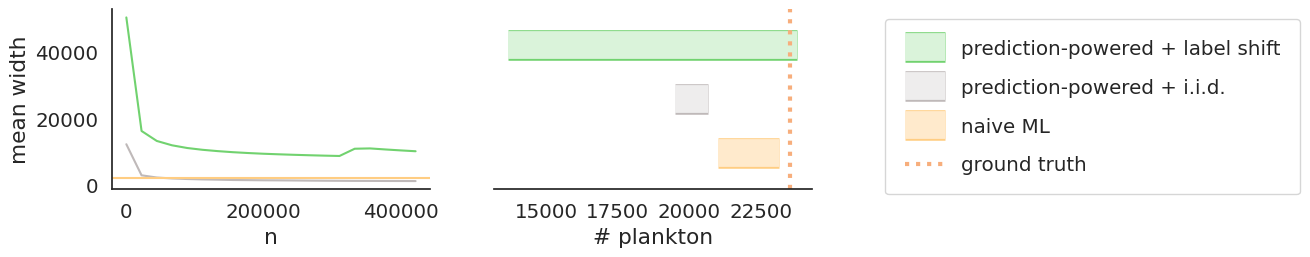

In [43]:
df = pd.read_pickle('./.cache/plankton-results.pkl')
make_plots(df, true_count)